In [1]:
from pathlib import Path
from acm.estimators import WaveletScatteringTransform, DensitySplit
from acm.utils import setup_logging
from pypower import mpi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

setup_logging()

# read some random galaxy catalog
data_dir = '/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior2/c000_ph000/'
data_fn = Path(data_dir) / 'hod3177.npy'
data = np.load(data_fn, allow_pickle=True).item()
boxsize = 2000.0
x = data['x']
y = data['y']
z_rsd = data['z_rsd']
data_positions = np.c_[x, y, z_rsd]

In [ ]:
import multiprocessing
nthreads = multiprocessing.cpu_count()
print(f'Running notebook with {nthreads} threads') 

### Calculate density quantiles

[000000.07]  03-22 15:34  DensitySplit                 INFO     Initializing DensitySplit.
[000000.08]  03-22 15:34  DensitySplit                 INFO     Box size: [2000. 2000. 2000.]
[000000.08]  03-22 15:34  DensitySplit                 INFO     Box center: [1000. 1000. 1000.]
[000000.08]  03-22 15:34  DensitySplit                 INFO     Box nmesh: [125 125 125]
[000000.38]  03-22 15:34  DensitySplit                 INFO     Setting density contrast.
[000000.46]  03-22 15:34  FFTWEngine                   INFO     Loading wisdom from wisdom.shape-125-125-125.type-float64.nthreads-256.npy.
[000016.34]  03-22 15:34  FFTWEngine                   INFO     Saving wisdom to wisdom.shape-125-125-125.type-float64.nthreads-256.npy.
[000016.48]  03-22 15:34  DensitySplit                 INFO     Generating random query points within the box.
[000019.60]  03-22 15:34  DensitySplit                 INFO     Quantiles calculated in 1.33 seconds.


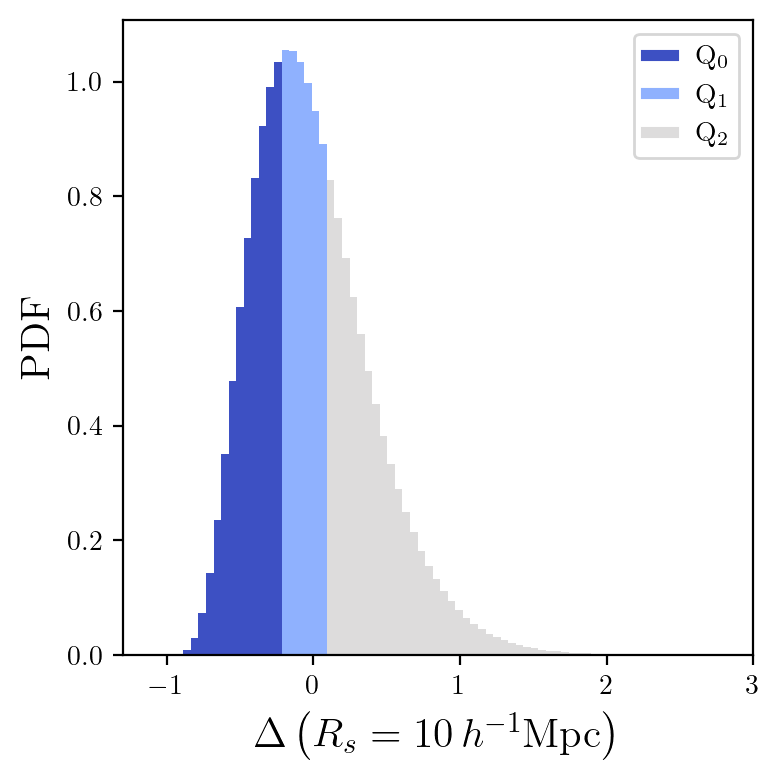

In [2]:
# calculate density splits
ds = DensitySplit(boxsize=boxsize, boxcenter=boxsize/2, cellsize=16.0)
ds.assign_data(positions=data_positions)
ds.set_density_contrast(smoothing_radius=10, query_method='randoms')
ds.set_quantiles(nquantiles=3)

ds.plot_quantiles()
plt.show()

### Calculate clustering in configuration space

[000021.41]  03-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000021.41]  03-22 15:34  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000021.41]  03-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000025.51]  03-22 15:34  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000025.51]  03-22 15:34  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 4.10 s.
[000025.51]  03-22 15:34  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000025.51]  03-22 15:34  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000025.52]  03-22 15:34  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000029.05]  03-22 15:34  TwoPointCorrelationFunction  INFO     Using precomputed two-point counts R1R2.
[000029

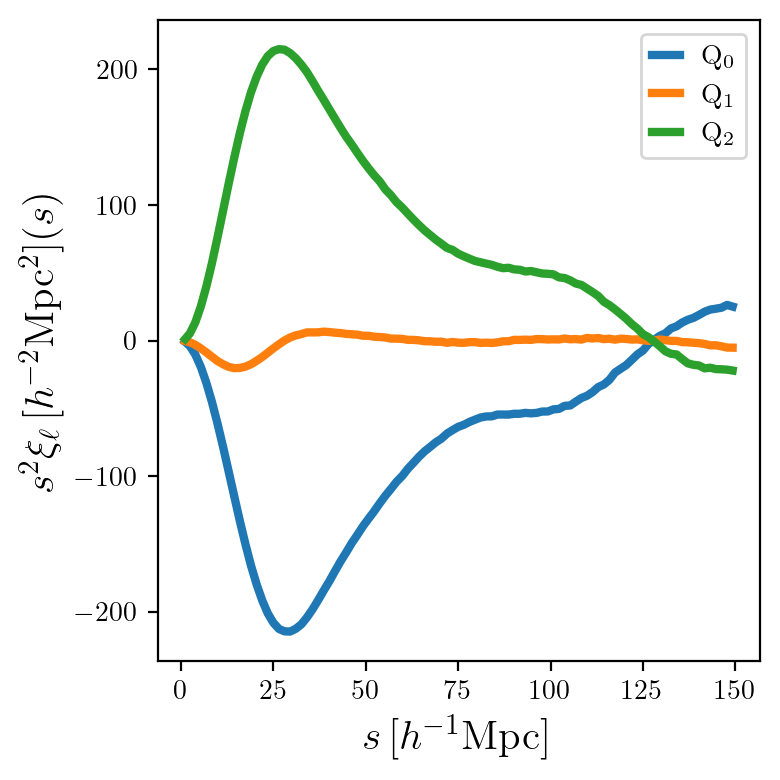

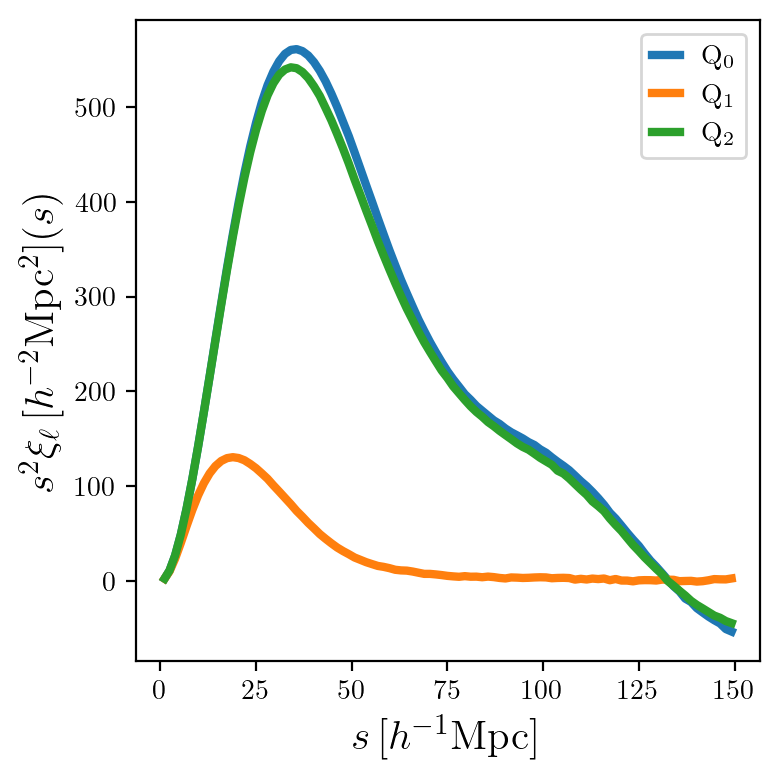

In [3]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
ds.quantile_data_correlation(data_positions, edges=(sedges, muedges), los='z', nthreads=256)
ds.quantile_correlation(edges=(sedges, muedges), los='z', nthreads=256)

ds.plot_quantile_data_correlation(ell=0)
ds.plot_quantile_correlation(ell=0)
plt.show()

### Calculate clustering in Fourier space

[000049.05]  03-22 15:34  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[2000. 2000. 2000.], boxcenter=[1000.00016365  999.99993896  999.9999357 ], dtype=float64).
[000049.16]  03-22 15:34  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 6662629.
[000050.95]  03-22 15:34  CatalogMesh                  INFO     Painted 4194304 out of 6662629 objects to mesh.
[000050.95]  03-22 15:34  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 6662629.
[000052.01]  03-22 15:34  CatalogMesh                  INFO     Painted 6662629 out of 6662629 objects to mesh.
[000052.01]  03-22 15:34  CatalogMesh                  INFO     Running interlacing at order 2.
[000052.32]  03-22 15:34  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 6662629.
[000054.08]  03-22 15:34  CatalogMesh                  INFO     Painted 4194304 out of 6662629 objects to mesh.
[000054.09]  03-22 15:34  CatalogMesh                  INFO   

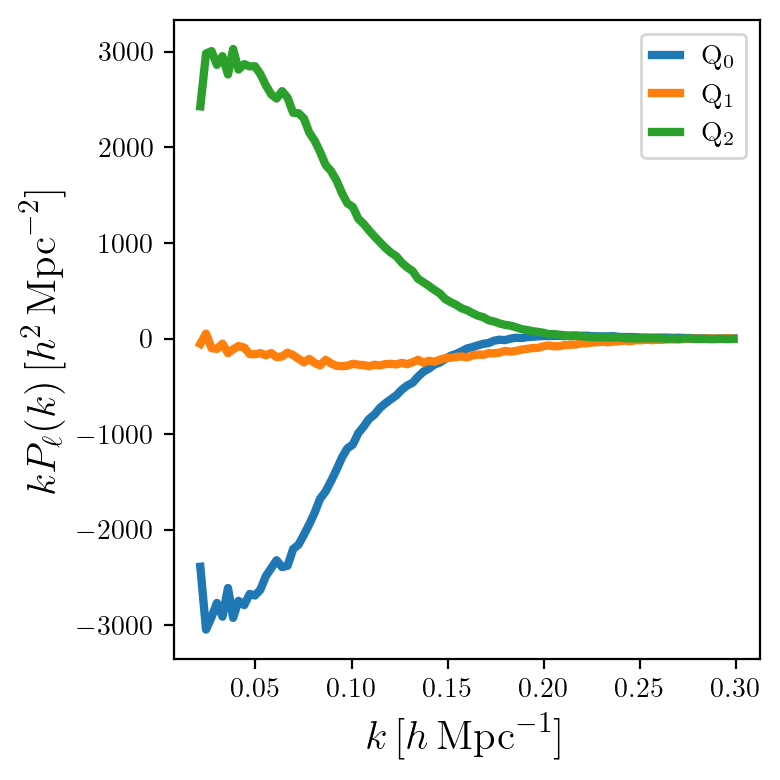

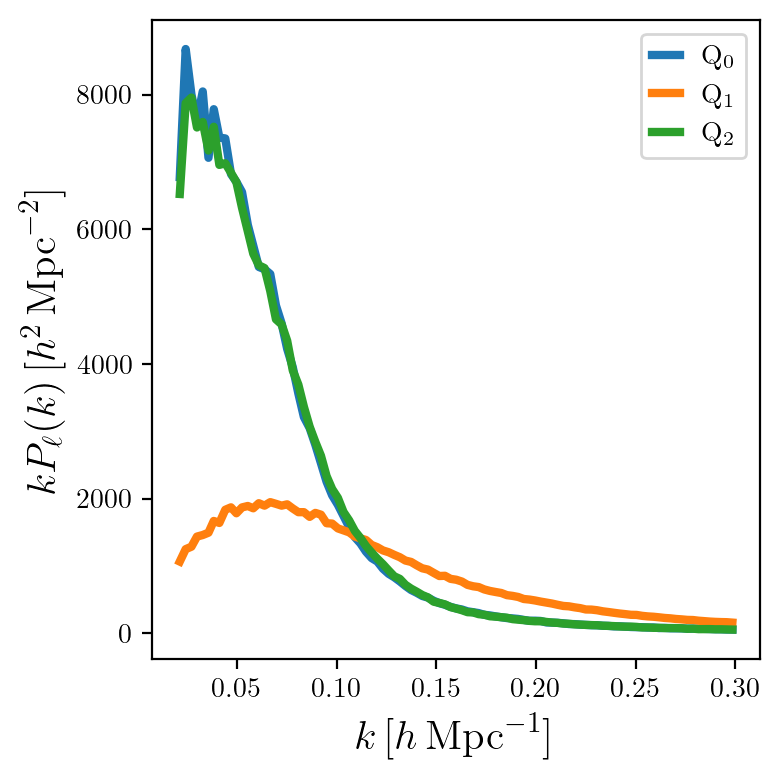

In [4]:
edges = np.linspace(0.02, 0.3, 100)
ds.quantile_data_power(data_positions, edges=edges, los='z')
ds.quantile_power(edges=edges, los='z')

ds.plot_quantile_data_power(ell=0)
ds.plot_quantile_power(ell=0)
plt.show()

### Working with survey data

In [5]:
from pathlib import Path
import fitsio
from cosmoprimo.fiducial import DESI
from pyrecon.utils import sky_to_cartesian
from acm.estimators import DensitySplit
from acm.utils import setup_logging
import logging
import argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


def read_desi(filename, distance, zmin=0.45, zmax=0.6):
    """Read CMASS LSS catalogues."""
    data = fitsio.read(filename)
    mask = (data['Z'] > zmin) & (data['Z'] < zmax)
    ra = data[mask]['RA']
    dec = data[mask]['DEC']
    redshift = data[mask]['Z']
    weights = data[mask]['WEIGHT']
    dist = distance(redshift)
    positions = sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    return positions, weights

setup_logging()
cosmo = DESI()
distance = cosmo.comoving_radial_distance

version = 'v1.2/blinded'
tracer = 'LRG'
zmin, zmax = 0.4, 0.6
region = 'NGC'
nrandoms = 5

# read data
data_dir = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{version}'
data_fn = Path(data_dir) / f'{tracer}_{region}_clustering.dat.fits'
data_positions, data_weights = read_desi(distance=distance, filename=data_fn, zmin=zmin, zmax=zmax)

# read randoms
randoms_positions = []
randoms_weights = []
for i in range(nrandoms):
    randoms_dir = Path('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.1/blinded/')
    randoms_fn = randoms_dir / f'{tracer}_{region}_{i}_clustering.ran.fits'
    randoms_positions_i, randoms_weights_i = read_desi(distance=distance, filename=randoms_fn,
                                                       zmin=zmin, zmax=zmax)
    randoms_positions.append(randoms_positions_i)
    randoms_weights.append(randoms_weights_i)
randoms_positions = np.concatenate(randoms_positions)
randoms_weights = np.concatenate(randoms_weights)

[000116.72]  03-22 15:35  jax._src.xla_bridge          INFO     Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
[000116.72]  03-22 15:35  jax._src.xla_bridge          INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
[000116.74]  03-22 15:35  jax._src.xla_bridge          INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2024-03-22 15:35:57.878067: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[000019.12]  03-22 15:36  DensitySplit                 INFO     Initializing DensitySplit.
[000019.16]  03-22 15:36  DensitySplit                 INFO     Box size: [2740. 4235. 2660.]
[000019.16]  03-22 15:36  DensitySplit                 INFO     Box center: [-621.63848301  -84.969653    618.97756546]
[000019.16]  03-22 15:36  DensitySplit                 INFO     Box nmesh: [548 847 532]
[000020.03]  03-22 15:36  DensitySplit                 INFO     Setting density contrast.
[000020.04]  03-22 15:36  FFTWEngine                   INFO     Loading wisdom from wisdom.shape-548-847-532.type-float64.nthreads-256.npy.
[000020.17]  03-22 15:36  FFTWEngine                   INFO     Saving wisdom to wisdom.shape-548-847-532.type-float64.nthreads-256.npy.
[000021.94]  03-22 15:36  FFTWEngine                   INFO     Loading wisdom from wisdom.shape-548-847-532.type-float64.nthreads-256.npy.
[000022.07]  03-22 15:36  FFTWEngine                   INFO     Saving wisdom to wisdom.shape-548-8

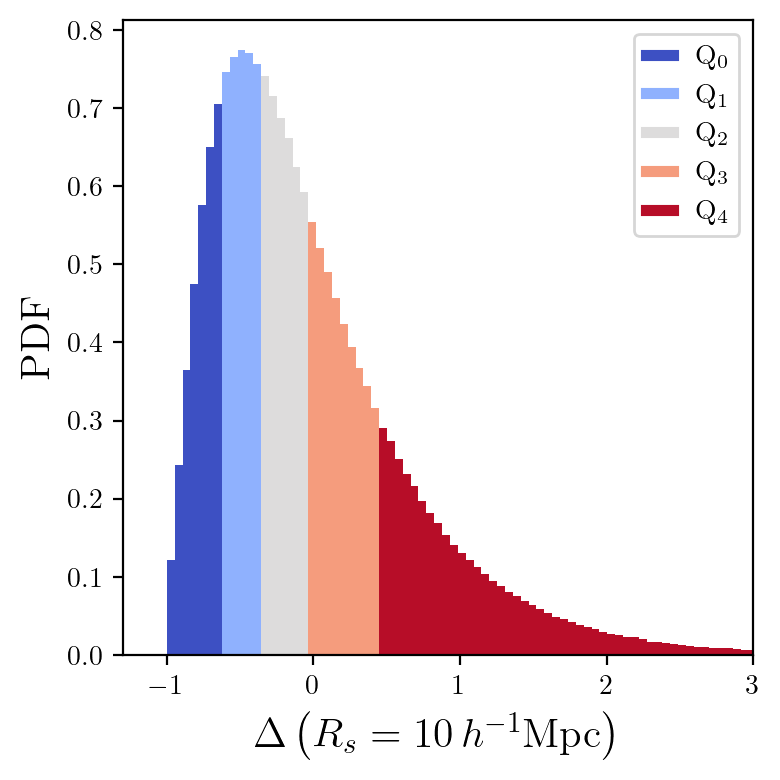

In [6]:
# note: when working with a non-uniform geometry, we need to explicitly
# define the query positions at which we want to sample the density field
nquery = 5 * len(data_positions)
idx = np.random.choice(len(randoms_positions), size=nquery)
query_positions = randoms_positions[idx]

ds = DensitySplit(positions=randoms_positions, cellsize=5.0)
ds.assign_data(positions=data_positions, weights=data_weights)
ds.assign_randoms(positions=randoms_positions, weights=randoms_weights)
ds.set_density_contrast(smoothing_radius=10, query_positions=query_positions)
ds.set_quantiles(nquantiles=5)

ds.plot_quantiles()
plt.show()

[000026.26]  03-22 15:36  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000026.26]  03-22 15:36  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000026.26]  03-22 15:36  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000026.67]  03-22 15:36  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000029.87]  03-22 15:36  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000034.08]  03-22 15:36  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000101.28]  03-22 15:37  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 75.02 s.
[000101.28]  03-22 15:37  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000101.28]  03-22 15:37  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000101.28]  03-22 

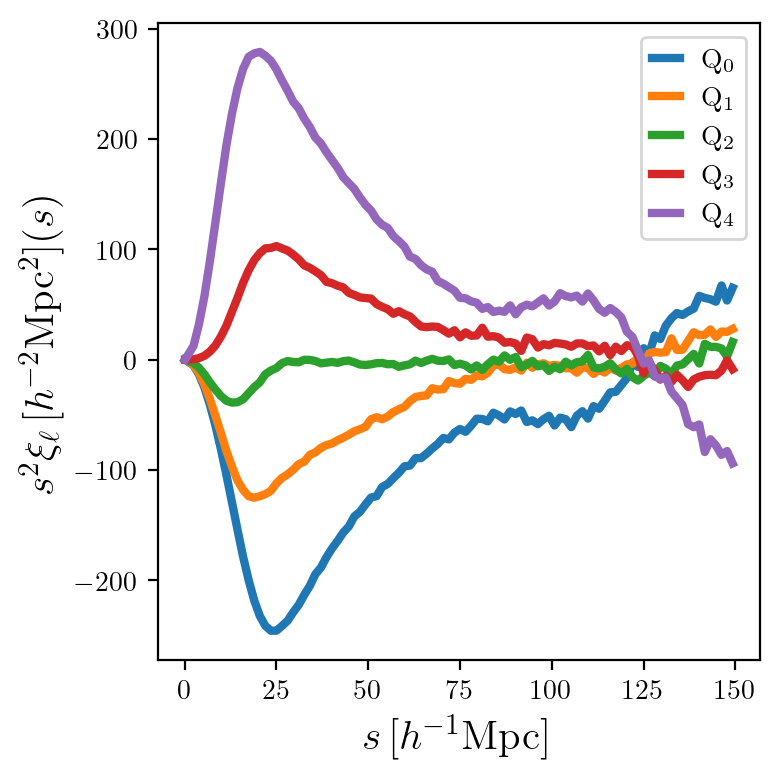

In [7]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
ds.quantile_data_correlation(data_positions=data_positions, randoms_positions=randoms_positions,
                             data_weights=data_weights, randoms_weights=randoms_weights,
                             edges=(sedges, muedges), los='midpoint', nthreads=256)

ds.plot_quantile_data_correlation(ell=0)
plt.show()